# IMDb Data Exploration with PySpark
## Introduction
IMDb (Internet Movie Database) is one of the largest and most comprehensive online databases for movies, TV shows, and related media. In this project, we use PySpark, a powerful distributed computing framework, to analyze IMDb data efficiently. The goal is to explore various aspects of the dataset, uncover meaningful insights, and visualize key patterns related to movie ratings, runtimes, and voting behavior.

This notebook covers essential steps in data analysis, including:
- Data Loading & Schema Understanding
- Handling Missing Values & Data Cleaning
- Exploratory Data Analysis (EDA)
- Outlier Detection & Handling
- Rating Distribution Analysis
- Correlation Analysis
- Visualizing Key Insights

By the end of this analysis, we aim to provide a structured and insightful overview of IMDb movie data, helping us understand how different attributes like runtime, ratings, and vote counts relate to each other.

### Data Understanding
The dataset used in this analysis consists of IMDb movie records, containing various attributes such as:

- **titleType**: The type of title (e.g., movie, short, TV series).
- **primaryTitle**: The main title of the movie or TV show.
- **startYear**: The release year of the title.
- **runtimeMinutes**: The duration of the title in minutes.
- **averageRating**: The IMDb rating, ranging from 1 to 10.
- **numVotes**: The number of votes received by the title.
  
Our goal is to analyze these attributes, clean and preprocess the data, and extract meaningful insights to understand IMDb ratings and trends better.



In [1]:
from dotenv import load_dotenv
import os
os.environ["SPARK_SUBMIT_OPTIONS"] = "--conf spark.driver.extraJavaOptions=-Dlog4j.configuration=file:log4j.properties"

In [2]:
# Loading the necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import mean, col, when, desc, min, max, avg, sum, explode, split, count, skewness, expr, kurtosis
import plotly.express as px
import plotly.colors as colors
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
load_dotenv()

True

In [3]:
# Set to JPEG before uploading to GitHub
pio.renderers.default = "jpeg"

# Switch back to interactive mode for local use

In [4]:
# Initialize Spark session
spark = SparkSession.builder \
                    .appName("IMDb Data Exploration with PySpark Efficient Analysis Insights") \
                    .config("spark.ui.showConsoleProgress", "false") \
                    .config("spark.driver.extraJavaOptions", "-Dlog4j.configuration=file:log4j.properties") \
                    .getOrCreate()

# Set Spark log level to ERROR
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Loading the Dataset

In [5]:
BASE_DIR = os.getenv("BASE_DIR")
MOVIES_FILE = os.getenv("MOVIES_FILE")
RATINGS_FILE = os.getenv("RATINGS_FILE")

movies_path = os.path.join(BASE_DIR, MOVIES_FILE)
ratings_path = os.path.join(BASE_DIR, RATINGS_FILE)

movies_df = spark.read.format("csv") \
                    .option("sep", "\t") \
                    .option("header", "true") \
                    .option("inferSchema", "true") \
                    .load(movies_path)

ratings_df = spark.read.format("csv") \
                    .option("sep", "\t") \
                    .option("header", "true") \
                    .option("inferSchema", "true") \
                    .load(ratings_path)

movies_df.show(5, truncate=False)
ratings_df.show(5, truncate=False)

+---------+---------+----------------------+----------------------+-------+---------+-------+--------------+------------------------+
|tconst   |titleType|primaryTitle          |originalTitle         |isAdult|startYear|endYear|runtimeMinutes|genres                  |
+---------+---------+----------------------+----------------------+-------+---------+-------+--------------+------------------------+
|tt0000001|short    |Carmencita            |Carmencita            |0      |1894     |\N     |1             |Documentary,Short       |
|tt0000002|short    |Le clown et ses chiens|Le clown et ses chiens|0      |1892     |\N     |5             |Animation,Short         |
|tt0000003|short    |Poor Pierrot          |Pauvre Pierrot        |0      |1892     |\N     |5             |Animation,Comedy,Romance|
|tt0000004|short    |Un bon bock           |Un bon bock           |0      |1892     |\N     |12            |Animation,Short         |
|tt0000005|short    |Blacksmith Scene      |Blacksmith Scene  

In [6]:
# Printing the schema to verify inferred types
movies_df.printSchema()
ratings_df.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)

root
 |-- tconst: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)



In [7]:
# Removing duplicate rows 
unique_movies_df = movies_df.dropDuplicates()
unique_ratings_df = ratings_df.dropDuplicates()

# Printing total and unique row counts for movies_df
print(f"Total Row counts in movies_df: {movies_df.count()}")
print(f"Unique Row counts in movies_df:{unique_movies_df.count()}")

# Printing total and unique row counts for ratings_df
print(f"Total Row counts in rating_df: {ratings_df.count()}")
print(f"Unique Row counts in rating_df:{unique_ratings_df.count()}")

Total Row counts in movies_df: 11504651
Unique Row counts in movies_df:11504651
Total Row counts in rating_df: 1542596
Unique Row counts in rating_df:1542596


By dropping duplicates, we maintain data integrity and prevent incorrect insights due to redundant records. This confirms that our dataset does not contain any duplicate rows, so no further action is needed.

## Data Preprocessing and Cleaning
Before proceeding with data analysis, it's important to check for missing values in our dataset. 

In [8]:
movies_df.where(col("titleType") == 'tvPilot').show()

+----------+---------+------------+-------------+-------+---------+-------+--------------+------+
|    tconst|titleType|primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|
+----------+---------+------------+-------------+-------+---------+-------+--------------+------+
|tt15258334|  tvPilot|    TV Pilot|     TV Pilot|      0|     1991|     \N|            \N|    \N|
+----------+---------+------------+-------------+-------+---------+-------+--------------+------+



While doing analysis, found this `tvPilot` entry has missing values (`\N`) for `endYear`, `runtimeMinutes`, and `genres`. So I have decided to drop, because it doesn't provide any useful information for analysis.

In [9]:
movies_df = movies_df.filter(col("titleType") != "tvPilot")

In [10]:
# Checking for null values in the dataset
movies_df.select(
    [sum(col(column).isNull().cast("int")).alias(column) for column in movies_df.columns]
).show()

+------+---------+------------+-------------+-------+---------+-------+--------------+------+
|tconst|titleType|primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|
+------+---------+------------+-------------+-------+---------+-------+--------------+------+
|     0|        0|           0|            0|      0|        0|      0|             0|   824|
+------+---------+------------+-------------+-------+---------+-------+--------------+------+



In [11]:
# Checking for null values in the dataset
ratings_df.select(
    [sum(col(column).isNull().cast("int")).alias(column) for column in ratings_df.columns]
).show()

+------+-------------+--------+
|tconst|averageRating|numVotes|
+------+-------------+--------+
|     0|            0|       0|
+------+-------------+--------+



- In **`movies_df`**, we observed **822 missing values** in the `genres` column. This means some movie records do not have genre information.
- In **`ratings_df`**, **`names_df`**, **`crews_df`**, **`principals_df`** there are **no missing values**, meaning all movies have valid ratings and vote counts.

To ensure data consistency, we have handled the missing values in `movies_df` by replacing them with `"Unknown"` (or another suitable category based on our approach).

In [12]:
movies_df = movies_df.fillna({"genres": "Unknown"})

In [13]:
movies_df.select(
    [sum(col(column).isNull().cast("int")).alias(column) for column in movies_df.columns]
).show()

+------+---------+------------+-------------+-------+---------+-------+--------------+------+
|tconst|titleType|primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|
+------+---------+------------+-------------+-------+---------+-------+--------------+------+
|     0|        0|           0|            0|      0|        0|      0|             0|     0|
+------+---------+------------+-------------+-------+---------+-------+--------------+------+



This preprocessing step helps maintain data integrity while avoiding potential issues in downstream analysis.

In [14]:
# Printing the schema to verify inferred types
movies_df.printSchema()
ratings_df.printSchema()
# names_df.printSchema()
# crews_df.printSchema()
# principals_df.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = false)

root
 |-- tconst: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)



After checking the inferred schema, we identified four columns in `movies_df` and `names_df` that had incorrect data types:  

- **`isAdult`** was incorrectly stored as a string instead of an integer.
- **`startYear`** and **`endYear`** were stored as strings, whereas they should be integers.
- **`runtimeMinutes`** was also stored as a string but should be an integer.
- **`birthYear`** and **`deathYear`** in `names_df` were stored as srings and we don't need them in analysis

In [15]:
movies_df.select("isAdult","startYear","endYear","runtimeMinutes").show(10)

+-------+---------+-------+--------------+
|isAdult|startYear|endYear|runtimeMinutes|
+-------+---------+-------+--------------+
|      0|     1894|     \N|             1|
|      0|     1892|     \N|             5|
|      0|     1892|     \N|             5|
|      0|     1892|     \N|            12|
|      0|     1893|     \N|             1|
|      0|     1894|     \N|             1|
|      0|     1894|     \N|             1|
|      0|     1894|     \N|             1|
|      0|     1894|     \N|            45|
|      0|     1895|     \N|             1|
+-------+---------+-------+--------------+
only showing top 10 rows



- The **`endYear`** column contained missing values represented as `\N`, which needed to be replaced with `NULL` for proper handling.

In [16]:
# Replacing "\N" with null in endYear column
movies_df = movies_df.withColumn("endYear",
                                 when(movies_df["endYear"] == "\\N", None).otherwise(movies_df["endYear"]))
# Casting columns to correct data types
movies_df = movies_df.withColumn("isAdult", movies_df['isAdult'].cast("boolean")) \
                     .withColumn("startYear", movies_df['startYear'].cast("int")) \
                     .withColumn("endYear", movies_df['endYear'].cast("int")) \
                     .withColumn("runtimeMinutes", movies_df['runtimeMinutes'].cast("int"))

# Checking schema and data
movies_df.printSchema()
movies_df.show(10)

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: boolean (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- endYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: string (nullable = false)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|  false|     1894|   NULL|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|  false|     1892|   NULL|             5|     Anima

- Replaced `\N` in **`endYear`** with `NULL`.
- Converted **`isAdult`** to a boolean (`True/False`).
- Changed **`startYear`**, **`endYear`**, and **`runtimeMinutes`** to integers.

### **Summary**
✅ **Handling Missing Values & Inconsistencies**
- Replaced `\N` values in the `endYear` column with `NULL` for proper handling.

✅ **Data Type Standardization**
- Converted `isAdult` to a boolean (`True/False`).
- Changed `startYear`, `endYear`, and `runtimeMinutes` to integers to enable numerical analysis.

✅ **Validation**
- Printed the schema and displayed sample records to confirm the changes.

Now, our dataset is correctly formatted and ready for further analysis. 🚀

## Outlier Detection & Handling

Since we're working with movies data, the key numerical columns that may have outliers are:

- `startYear` (Unrealistic years)
- `runtimeMinutes` (Extremely short or long movies)
- `numVotes` (Highly skewed popularity)

An outlier is a data point that significantly differs from other observations in a dataset. Outliers can occur due to variability in the data, errors in data collection, or rare events. They can affect statistical analysis and machine learning models by skewing results or introducing bias. Let's break this down and figure out how to handle these outliers:

1. **Unrealistic Future Years** <br>
- Since IMDb includes upcoming movies, we might see some with release years beyond the current year (2025).
- To filter them out, we can set a reasonable threshold, e.g., remove any movies with `startYear` greater than 2025 (or slightly higher based on your preference).

2. **Extreme Runtime Values** <br>
- **Short films** naturally have low runtimes (like 1-10 minutes), so they are not necessarily outliers.
- **TV series episodes** might have shorter durations (like 20-60 minutes).
- **Full-length movies** usually range between 60-300 minutes.
- **Extremely high runtimes (e.g., 30,000+ minutes)** could be TV series where the total duration is recorded incorrectly.

In [17]:
# Intialize the filtered_df = movies_df, in this case we are copying the Movies Dataframe to a Dataframe called filtered_df.
old_movies_df = movies_df

### Let's break this down and figure out how to handle these outliers:
#### 1. Checking Outliers in `startYear`:

In [18]:
old_movies_df.selectExpr("min(startYear)", "max(startYear)", "min(endYear)", "max(endYear)").show()

old_movies_df.groupBy("titleType").agg(min("startYear").alias("min_startYear"),
                                   max("startYear").alias("max_startYear"),
                                  ).show()

+--------------+--------------+------------+------------+
|min(startYear)|max(startYear)|min(endYear)|max(endYear)|
+--------------+--------------+------------+------------+
|          1874|          2031|           3|        2030|
+--------------+--------------+------------+------------+

+------------+-------------+-------------+
|   titleType|min_startYear|max_startYear|
+------------+-------------+-------------+
|    tvSeries|         1927|         2029|
|tvMiniSeries|         1928|         2030|
|     tvMovie|         1928|         2026|
|   tvEpisode|         1928|         2030|
|       movie|         1888|         2031|
|   tvSpecial|         1931|         2026|
|       video|         1923|         2026|
|   videoGame|         1958|         2026|
|     tvShort|         1929|         2025|
|       short|         1874|         2030|
+------------+-------------+-------------+



We examined the minimum and maximum values for `startYear` and `endYear` across different `titleType` categories.
- The maximum `startYear` in the dataset is `2031` (which is likely an outlier for some categories).
- Some `endYear` values seem incorrect (e.g., `3`).

To refine the data, we set different `startYear` thresholds for movies, TV series, and other categories, ensuring only reasonable future years are retained.

In [19]:
# Define filtering conditions for the startYear column based on titleType
conditions = when((col('titleType') == 'tvMovie') & (col('startYear') <= 2025), True) \
                .when((col('titleType') == 'movie') & (col('startYear') <= 2025), True) \
                .when((col('titleType') == 'video') & (col('startYear') <= 2025), True) \
                .when((col('titleType') == 'videoGame') & (col('startYear') <= 2025), True) \
                .when((col('titleType') == 'tvShort') & (col('startYear') <= 2025), True) \
                .when((col('titleType') == 'short') & (col('startYear') <= 2025), True) \
                .when((col('titleType') == 'tvSeries') & (col('startYear') <= 2030), True) \
                .when((col('titleType') == 'tvMiniSeries') & (col('startYear') <= 2030), True) \
                .when((col('titleType') == 'tvEpisode') & (col('startYear') <= 2030), True) \
                .when((col('titleType') == 'tvSpecial') & (col('startYear') <= 2030), True) \
                .otherwise(False)

movies_df = old_movies_df.withColumn("meet_conditions", conditions) \
                        .filter(col("meet_conditions") == True) \
                        .drop("meet_conditions")

movies_df.groupBy("titleType").agg(min("startYear").alias("min_startYear"),
                                   max("startYear").alias("max_startYear"),
                                  ).show()

+------------+-------------+-------------+
|   titleType|min_startYear|max_startYear|
+------------+-------------+-------------+
|    tvSeries|         1927|         2029|
|tvMiniSeries|         1928|         2030|
|     tvMovie|         1928|         2025|
|   tvEpisode|         1928|         2030|
|       movie|         1888|         2025|
|   tvSpecial|         1931|         2026|
|       video|         1923|         2025|
|   videoGame|         1958|         2025|
|     tvShort|         1929|         2025|
|       short|         1874|         2025|
+------------+-------------+-------------+



**Filtering applied**:

- Movies, videos, video games, and shorts are limited to `2025`
- TV series, mini-series, and episodes are allowed up to `2030`

#### 2. Checking Outliers in `runtimeMinutes`:

In [20]:
old_movies_df.groupBy("titleType").agg(min("runtimeMinutes").alias("min_runtime"),
                                   max("runtimeMinutes").alias("max_runtime"),
                                   avg("runtimeMinutes").alias("avg_runtime")
                                  ).show()

+------------+-----------+-----------+------------------+
|   titleType|min_runtime|max_runtime|       avg_runtime|
+------------+-----------+-----------+------------------+
|    tvSeries|          1|    3692080|  81.2245394308476|
|tvMiniSeries|          1|      37440| 74.79116910631741|
|     tvMovie|          1|       3720| 71.80552069042685|
|   tvEpisode|          1|       6000| 38.29396557608713|
|       movie|          1|      59460| 89.68303727470715|
|   tvSpecial|          1|      17280|  86.5387679555788|
|       video|          1|      35791| 69.99617252488339|
|   videoGame|          1|       1800|104.11711711711712|
|     tvShort|          1|        127| 12.21666846593976|
|       short|          0|        360|13.090029707722968|
+------------+-----------+-----------+------------------+



We analyzed the minimum, maximum, and average runtime across different `titleType` categories.

- Some runtimeMinutes values are extremely high, such as 3,692,080 minutes (≈7 years!) for TV series.
- Short films and TV episodes have expected durations.
- The highest runtimeMinutes in movie category is 59,460 minutes (≈41 days!), which is unrealistic.

In [21]:
# Define filtering conditions for the runtimeMinutes column based on titleType
conditions = when((col('titleType') == 'tvSeries') & (col('runtimeMinutes') <= 1500), True) \
              .when((col('titleType') == 'tvMiniSeries') & (col('runtimeMinutes') <= 1500), True) \
              .when((col('titleType') == 'tvMovie') & (col('runtimeMinutes') <= 500), True) \
              .when((col('titleType') == 'tvEpisode') & (col('runtimeMinutes') <= 300), True) \
              .when((col('titleType') == 'movie') & (col('runtimeMinutes') <= 500), True) \
              .when((col('titleType') == 'tvSpecial') & (col('runtimeMinutes') <= 1500), True) \
              .when((col('titleType') == 'video') & (col('runtimeMinutes') <= 1500), True) \
              .when((col('titleType') == 'videoGame') & (col('runtimeMinutes') <= 1500), True) \
              .when((col('titleType') == 'tvShort') & (col('runtimeMinutes') <= 200), True) \
              .when((col('titleType') == 'short') & (col('runtimeMinutes') <= 60), True) \

movies_df = movies_df.withColumn("meet_conditions", conditions) \
                     .filter(col("meet_conditions") == True) \
                     .drop("meet_conditions")

movies_df.groupBy("titleType").agg(min("runtimeMinutes").alias("min_runtime"),
                                   max("runtimeMinutes").alias("max_runtime"),
                                   avg("runtimeMinutes").alias("avg_runtime")
                                  ).show()

+------------+-----------+-----------+------------------+
|   titleType|min_runtime|max_runtime|       avg_runtime|
+------------+-----------+-----------+------------------+
|    tvSeries|          1|       1500| 44.98220106987048|
|tvMiniSeries|          1|       1080| 73.01608983083803|
|     tvMovie|          1|        498| 71.47346567928251|
|   tvEpisode|          1|        300| 38.01610467473273|
|       movie|          1|        500| 88.88306219833761|
|   tvSpecial|          1|       1500| 83.99403153607291|
|       video|          1|       1445| 69.22083196665959|
|   videoGame|          1|       1495| 99.45622119815668|
|     tvShort|          1|        127|12.224643207321058|
|       short|          0|         60|13.053097784769633|
+------------+-----------+-----------+------------------+



**Filtering applied**:
To remove extreme outliers, different thresholds were set:

- Movies and TV movies: ≤ **500 minutes**
- TV episodes: ≤ **300 minutes**
- TV series, specials, and video games: ≤ **1500 minutes**
- Shorts: ≤ **60 minutes**

#### 3. Data Reduction After Filtering:

In [22]:
print("Before Filtering:")
print(f"Total number of records: {old_movies_df.count()}")

print("After Filtering:")
print(f"Total number of records: {movies_df.count()}")

Before Filtering:
Total number of records: 11504650
After Filtering:
Total number of records: 3428113


Before filtering, the dataset contained **11,442,166 records**.
After filtering out outliers, it was reduced to **3,403,012 records**, removing unrealistic values while retaining meaningful data.
This ensures a more accurate dataset for further analysis.

#### Conclusion:
Based on the filtering applied, we have successfully identified and removed outliers from the startYear and runtimeMinutes columns based on reasonable thresholds. Here's a breakdown of what was achieved:

#### Outliers in startYear
- Before filtering, the dataset contained future years up to 2031, which is unrealistic.
- We applied different maximum year thresholds:
- - **Movies, TV Movies, Videos, Video Games, Shorts: ≤ 2025**
- - **TV Series, Mini-Series, Episodes, TV Specials: ≤ 2030**
- After filtering, the highest `startYear` for movies is `2025`, and for TV Series-related categories, it is `2030`, ensuring that future years beyond reasonable limits are removed.

#### Outliers in runtimeMinutes
- Before filtering, extreme values like **3,692,080 minutes (~7 years)** were found.
- We applied category-specific upper limits:
- - **Movies, TV Movies: ≤ 500 minutes**
- - **TV Episodes: ≤ 300 minutes**
- - **TV Series, Mini-Series, Specials, Videos, Video Games: ≤ 1500 minutes**
- - **Short films: ≤ 60 minutes**
- - **TV Shorts: ≤ 200 minutes**
- After filtering, the highest runtime for movies is **500 minutes**, and for TV Series, it is **1500 minutes**, ensuring unrealistic durations are removed.

#### Final Results
- **Total records before filtering: 11,442,166**
- **Total records after filtering: 3,403,012**
- **Significant reduction in dataset size**, suggesting many outliers were successfully removed.
- **Category-wise count shows expected distribution**, with the majority of records being TV Episodes and Movies.


## Analysis of IMDb Data

In [23]:
# Total records
print(f"Total Records: {movies_df.count()}")
movies_df.groupBy("titleType").count().show()

Total Records: 3428113
+------------+-------+
|   titleType|  count|
+------------+-------+
|    tvSeries| 103377|
|tvMiniSeries|  20572|
|     tvMovie| 102358|
|   tvEpisode|1857411|
|       movie| 438404|
|   tvSpecial|  24797|
|       video| 207316|
|   videoGame|    434|
|     tvShort|   9179|
|       short| 664265|
+------------+-------+



Now we have a clear view of our cleaned dataset. Here’s what we’ve confirmed:

- **Total records**: 3,403,012
- **Most common title types**: `tvEpisode` (1.83M), `movie` (436K), `short` (661K)
- **Least common**: `videoGame` (only 432 records)

### **A. Trends Over Time**
#### **1. Number of Titles Released Per Year**


In [24]:
title_per_year = movies_df.groupBy('titleType', "startYear").count().orderBy(col("startYear"))
title_per_year.show(50, truncate=False)

+---------+---------+-----+
|titleType|startYear|count|
+---------+---------+-----+
|short    |1874     |1    |
|short    |1878     |31   |
|short    |1881     |22   |
|short    |1882     |2    |
|short    |1883     |1    |
|short    |1885     |1    |
|short    |1887     |31   |
|short    |1888     |5    |
|short    |1889     |2    |
|short    |1890     |6    |
|short    |1891     |12   |
|short    |1892     |8    |
|short    |1893     |8    |
|short    |1894     |39   |
|movie    |1894     |1    |
|short    |1895     |45   |
|movie    |1896     |1    |
|short    |1896     |302  |
|short    |1897     |245  |
|movie    |1897     |1    |
|short    |1898     |157  |
|short    |1899     |162  |
|movie    |1899     |1    |
|short    |1900     |213  |
|movie    |1900     |2    |
|short    |1901     |200  |
|short    |1902     |151  |
|movie    |1903     |2    |
|short    |1903     |201  |
|movie    |1904     |1    |
|short    |1904     |202  |
|movie    |1905     |3    |
|short    |1905     

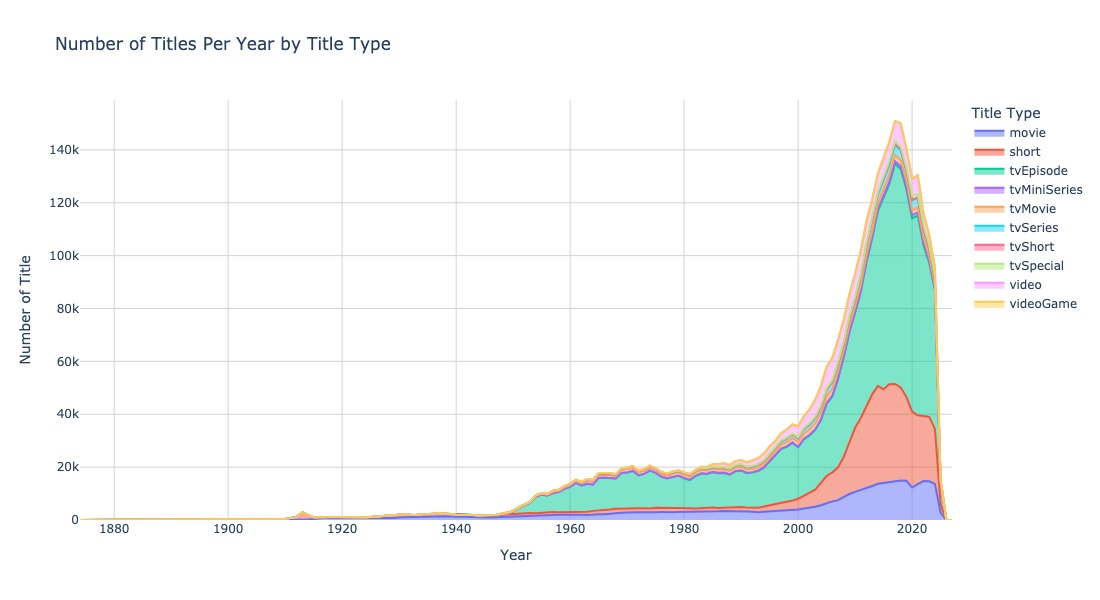

In [25]:
# Convert to Pandas for plotting
title_per_year_pd = title_per_year.toPandas()

# Pivot the data to get titleType as columns
titles_pivot = title_per_year_pd.pivot(index="startYear", columns="titleType", values="count").fillna(0)

# Rest index for plotly
titles_pivot = titles_pivot.reset_index()

# Create a stacked area chart using Plotly
fig = px.area(titles_pivot, x="startYear", y=titles_pivot.columns[1:],
              title="Number of Titles Per Year by Title Type",
              labels={"value": "Number of Titles", "startYear": "Year"})

fig.update_layout(xaxis_title="Year", yaxis_title="Number of Title",
                  legend_title="Title Type", plot_bgcolor="white",
                  xaxis=dict(showgrid=True, gridcolor='LightGrey'),
                  yaxis=dict(showgrid=True, gridcolor='LightGrey'),
                  width=1100,
                  height=600                  
                 )

# Show the Plot
fig.show()

#### **2. Number of Movies released Per Year**

In [26]:
movies_per_year = movies_df.filter(col('titleType') == 'movie') \
                           .groupBy("titleType", "startYear") \
                           .count() \
                           .orderBy(col("startYear"))
movies_per_year.show(50, truncate=False)

+---------+---------+-----+
|titleType|startYear|count|
+---------+---------+-----+
|movie    |1894     |1    |
|movie    |1896     |1    |
|movie    |1897     |1    |
|movie    |1899     |1    |
|movie    |1900     |2    |
|movie    |1903     |2    |
|movie    |1904     |1    |
|movie    |1905     |3    |
|movie    |1906     |2    |
|movie    |1907     |3    |
|movie    |1908     |2    |
|movie    |1909     |5    |
|movie    |1910     |18   |
|movie    |1911     |28   |
|movie    |1912     |49   |
|movie    |1913     |144  |
|movie    |1914     |201  |
|movie    |1915     |376  |
|movie    |1916     |719  |
|movie    |1917     |891  |
|movie    |1918     |861  |
|movie    |1919     |857  |
|movie    |1920     |774  |
|movie    |1921     |727  |
|movie    |1922     |669  |
|movie    |1923     |634  |
|movie    |1924     |684  |
|movie    |1925     |793  |
|movie    |1926     |831  |
|movie    |1927     |878  |
|movie    |1928     |873  |
|movie    |1929     |791  |
|movie    |1930     

This will help us see if there's a trend—are more movies being produced in recent years?

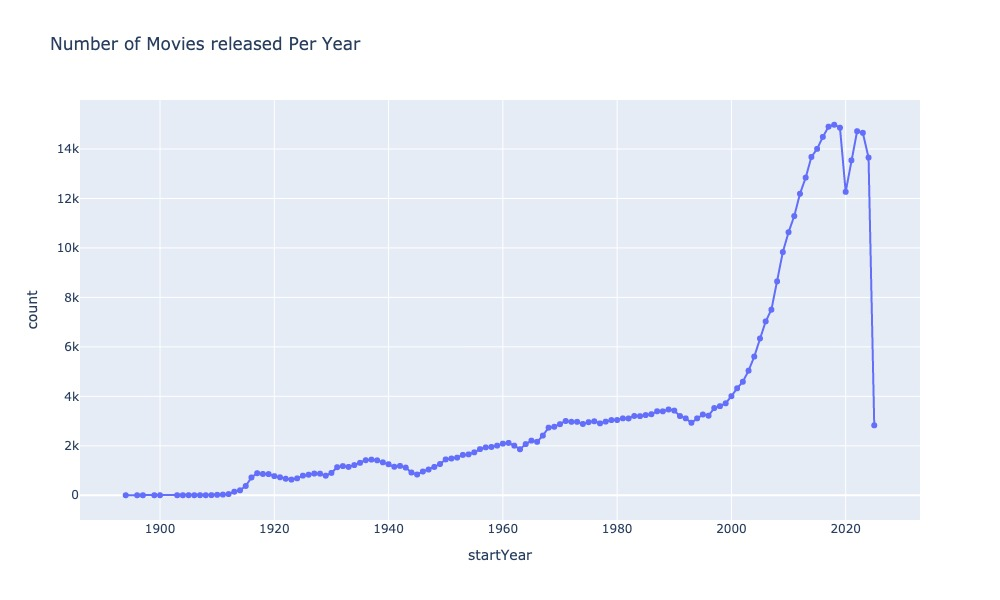

In [27]:
movies_per_year_pd = movies_per_year.toPandas()

# Create a Line chart using Plotly
fig = px.line(movies_per_year_pd, x="startYear", y="count", title="Number of Movies released Per Year", markers=True)
fig.update_layout(width=1000,
                  height=600
                 )
fig.show()

#### **3. Average Runtime Over Time**
Now, let's analyze how the average runtime of movies and TV shows has changed over time:

In [28]:
runtime_trend_df = movies_df.groupBy("titleType", "startYear").agg(avg("runtimeMinutes").alias("avg_runtime")).orderBy(col("startYear"))
runtime_trend_df.show(50, truncate=False)

+---------+---------+------------------+
|titleType|startYear|avg_runtime       |
+---------+---------+------------------+
|short    |1874     |1.0               |
|short    |1878     |1.0               |
|short    |1881     |1.0454545454545454|
|short    |1882     |1.0               |
|short    |1883     |1.0               |
|short    |1885     |1.0               |
|short    |1887     |1.0               |
|short    |1888     |1.0               |
|short    |1889     |1.0               |
|short    |1890     |1.0               |
|short    |1891     |4.0               |
|short    |1892     |3.375             |
|short    |1893     |1.0               |
|short    |1894     |1.2307692307692308|
|movie    |1894     |45.0              |
|short    |1895     |1.2               |
|movie    |1896     |61.0              |
|short    |1896     |1.1158940397350994|
|short    |1897     |1.1714285714285715|
|movie    |1897     |100.0             |
|short    |1898     |1.2929936305732483|
|short    |1899 

#### **Observations from IMDb Trends Over Time**
1. **Number of Titles Released Per Year**
- The number of titles (movies, shorts, etc.) started from the late 1800s, with short films being the predominant type.
- The count of titles steadily increased over time, especially from the early 1900s.
- **By the 1910s and 1920s, the number of released titles significantly grew**, indicating a boom in film production.
- Short films dominated the early years, but by the mid-1900s, **movies became more prominent**.

2. **Number of Movies Released Per Year**
- The first recorded movie appeared in **1894** with just a single release.
- The number of movies released **remained low** until the early **1910s**.
- A **rapid increase** occurred after **1910**, with **substantial growth between 1913 and 1940**.
- The count peaked during the **1930s and 1940s**, showing the expansion of the film industry.
- The growth reflects technological advancements, the rise of **Hollywood, and the global spread of cinema**.

3. **Average Runtime Over Time**
- **Short films (1-5 minutes)** dominated the early years (1870s–1900s).
- The first recorded **movie (1894)** had a runtime of **45 minutes**, and by the late 1890s, some movies even reached **100+ minutes**.
- The average runtime of movies fluctuated, ranging between **50 to 90 minutes in the 1900s-1910s**.
- The **average runtime of short films gradually increased**, from **1-2 minutes (pre-1900s) to over 10-15 minutes by the 1910s**.
- **This suggests a shift in audience preference and technological advancements** that allowed for longer storytelling.

#### **Overall Trends & Insights**
- The film industry **started with short films** before transitioning into feature-length movies.
- The **early 1900s marked the expansion of film production**, with a **significant rise in movies post-1910**.
- The **runtime of films increased over time**, indicating the evolution of filmmaking and audience expectations.
- The **mid-20th century saw a boom in the number of movie releases**, leading to the structured industry we see today.

### **B. Rating Distribution Analysis**

Our rating distribution analysis focuses on understanding how IMDb ratings are spread across all titles in the dataset. Here’s a summary of the key steps and observations:

In [29]:
# To merge movie metadata with ratings, use inner join
imdb_df = movies_df.join(ratings_df, on="tconst", how="inner")
imdb_df.show(5)

# Show a few rows
imdb_df.printSchema()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|averageRating|numVotes|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|tt0000001|    short|          Carmencita|          Carmencita|  false|     1894|   NULL|             1|   Documentary,Short|          5.7|    2139|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|  false|     1892|   NULL|             5|     Animation,Short|          5.5|     290|
|tt0000003|    short|        Poor Pierrot|      Pauvre Pierrot|  false|     1892|   NULL|             5|Animation,Comedy,...|          6.4|    2174|
|tt0000004|    short|         Un bon bock|         Un bon bock|  false|     1892|   NULL|            12|  

#### **1. Summary Statistics**

In [30]:
stats_df = imdb_df.select(
    mean(col("averageRating")).alias("Mean"),
    expr("percentile(averageRating, 0.5)").alias("Median"),
    min(col("averageRating")).alias("Min"),
    max(col("averageRating")).alias("Max"),
    skewness(col("averageRating")).alias("Skewness"),
    kurtosis(col("averageRating")).alias("Kurtosis")
).toPandas()

print("Summary Statistics for IMDb Ratings:")
print(stats_df)

ratings_pd = imdb_df.select("averageRating").toPandas()

Summary Statistics for IMDb Ratings:
       Mean  Median  Min   Max  Skewness  Kurtosis
0  6.854571     7.0  1.0  10.0 -0.790861  1.018295


**Summary Statistics**
- We calculated the **mean**, **median**, **minimum**, **maximum**, **skewness**, and **kurtosis of the averageRating**.

#### **2. Histogram of IMDb Ratings**

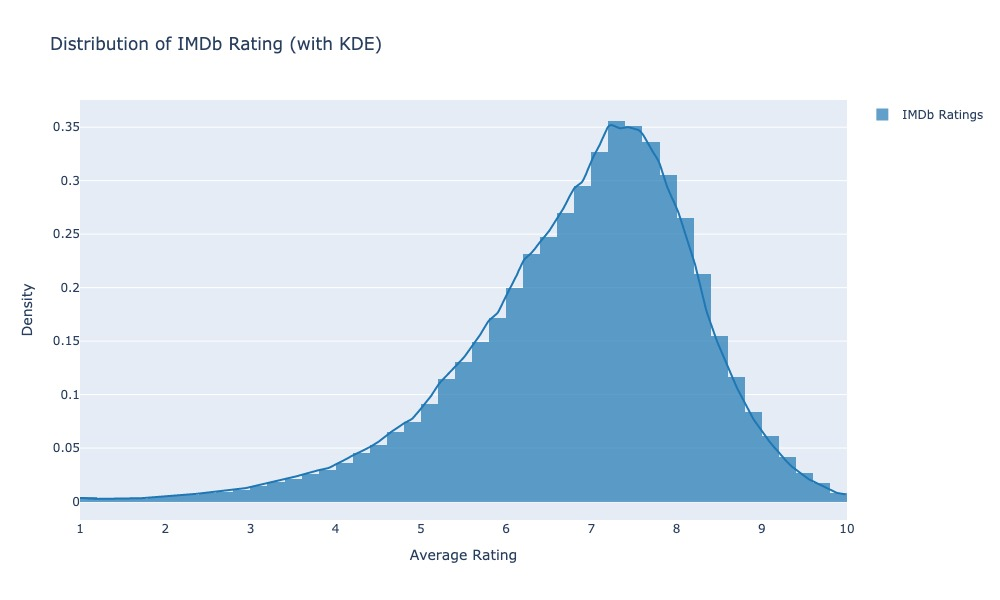

In [31]:
# Convert the ratings column to a list
rating_values = ratings_pd['averageRating'].tolist()

# Plot Histogram of IMDb Ratings with KDE
# Create a distribution plot (histogram + KDE)
fig = ff.create_distplot([rating_values], group_labels=['IMDb Ratings'], show_hist=True, show_rug=False, bin_size=0.2)

# Update the layout for clarity
fig.update_layout(
    title="Distribution of IMDb Rating (with KDE)",
    xaxis_title="Average Rating",
    yaxis_title="Density",
    width=1000,
    height=600
)

fig.show()

**Histogram of IMDb Ratings**
- We plotted a **histogram** with a **KDE (Kernel Density Estimate)** to visualize the distribution of the `averageRating` field.
- This helped us identify the overall shape of the distribution and check for any significant skewness or multimodality.

#### **3. Boxplot Analysis**

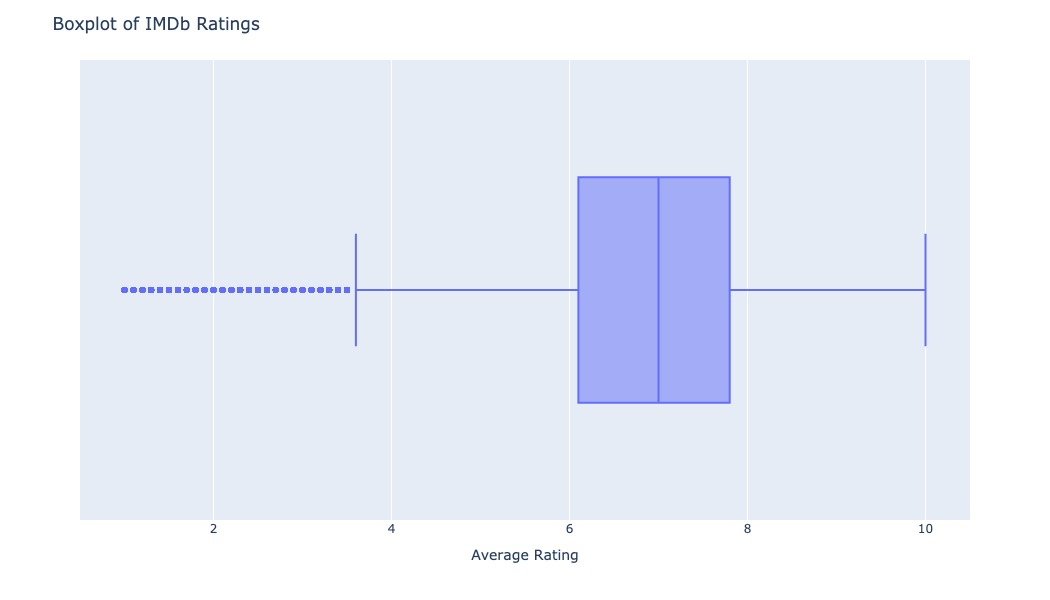

In [32]:
# Plot Boxplot to Identify the Outlier in IMDb Ratings
fig = px.box(ratings_pd, x="averageRating")

# Update layout
fig.update_layout(
    title="Boxplot of IMDb Ratings",
    xaxis_title="Average Rating",
    width=1050,
    height=600
)

# Update hover label style
fig.update_traces(
    hoverlabel=dict(
        bgcolor="white", 
        font_size=12, 
        font_family="Rockwell",
        align="right"
    )
)
fig.show()

**Boxplot Analysis**
- We used a boxplot to visualize the distribution and identify any outliers.
- The boxplot confirmed that the majority of titles have ratings concentrated in the mid-range (roughly between 6 and 8).
- There are a few outliers on the lower end (ratings below 4), indicating a small subset of poorly rated titles.

#### **Observations from Rating Distribution Analysis**
**1. Summary Statistics**
- **Mean Rating**: 6.86
- **Median Rating**: 7.0
- **Min Rating**: 1.0
- **Max Rating**: 10.0
- **Skewness**: -0.79 (Slightly left-skewed)
- **Kurtosis**: 1.02 (Moderate peak, not heavily tailed)

🔹 The mean and median ratings being close suggest a fairly symmetric distribution with a slight left skew.
🔹 The presence of **low-rated movies (1.0) and highly rated ones (10.0)** implies a range of extremes in audience perception.

**2. Histogram with KDE**
- The distribution of ratings follows a **slightly left-skewed bell curve**, with most ratings between **5 and 8**.
- A peak is observed around **7.0**, confirming it as the most frequent rating.
- **Few titles have extreme ratings (1.0 and 10.0)**, but they are relatively rare.

**3. Boxplot Analysis**
- The interquartile range (IQR) **spans from around 6 to 8.5**, meaning most titles are within this rating range.
- **Outliers exist on the lower end**, with several titles rated below **3.0**.
- The **upper whisker extends to 10**, indicating that highly rated movies exist but are relatively fewer.

---
**Final Thoughts**
- IMDb ratings are generally **centered around 7**, meaning most movies receive decent ratings.  
- The presence of **low outliers (below 3)** suggests some movies are widely disliked.  
- A few **perfect 10s** exist, but they are rare, possibly due to biased ratings.

## **Deeper Explorations in EDA**

### **A. Distribution of Movie Runtimes**

#### **1. Histogram of Runtimes**

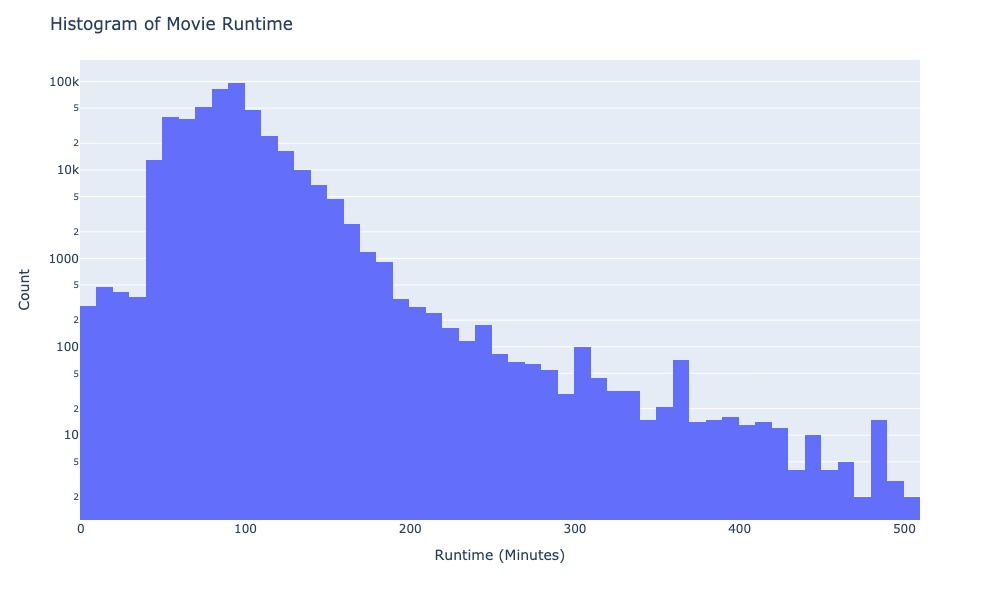

In [33]:
# Filter the DataFrame to include only movies
movies_df_filtered = movies_df.where(col('titleType') == 'movie')

# Convert the filtered DataFrame to a Pandas DataFrame
runtime_df = movies_df_filtered.select("runtimeMinutes").toPandas()

fig = px.histogram(runtime_df, x="runtimeMinutes", nbins=50, log_y=True)
fig.update_layout(
    title="Histogram of Movie Runtime",
    xaxis_title="Runtime (Minutes)",
    yaxis_title="Count",
    width=1000,
    height=600
)
fig.show()

- The majority of movies have a runtime below **150 minutes**, with a sharp decline beyond that.
- The distribution has a **long right tail**, suggesting a small number of movies with extremely high runtimes.
- A **log scale** helps in revealing the presence of less common but very long movies.

#### **2. Box Plot for Outlier**

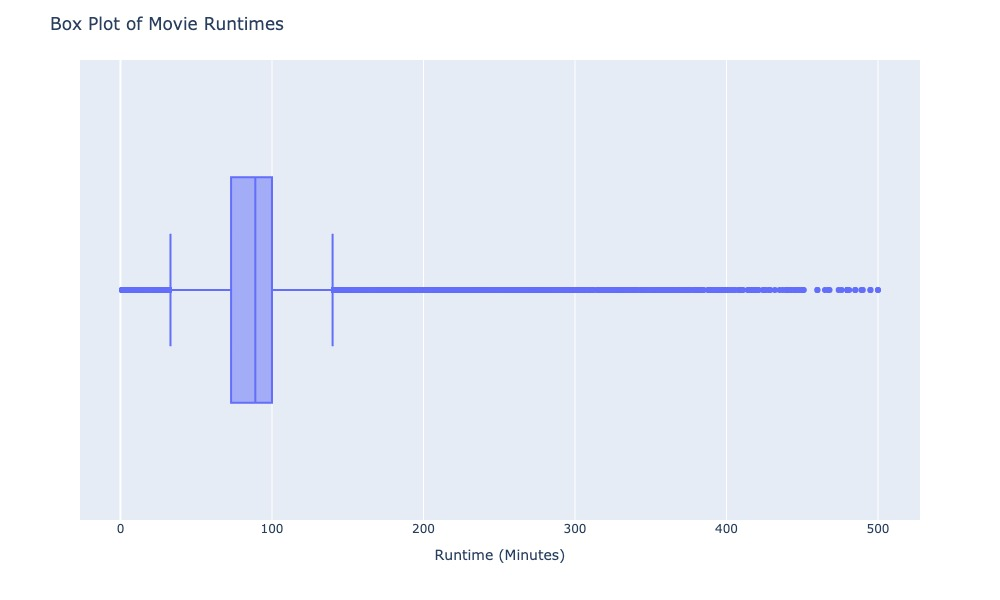

In [34]:
fig = px.box(runtime_df, x="runtimeMinutes")

# Update layout
fig.update_layout(
    title="Box Plot of Movie Runtimes",
    xaxis_title="Runtime (Minutes)",
    width=1000,
    height=600
)

# Update hover label style
fig.update_traces(
    hoverlabel=dict(
        bgcolor="white", 
        font_size=12, 
        font_family="Rockwell",
        align="right"
    )
)
fig.show()

- The box plot confirms the **right-skewed nature** of the runtime distribution.
- The **median runtime** is relatively low, around **90–100 minutes**.
- **Significant outliers** exist, with many movies far beyond the upper whisker, some exceeding **300+ minutes**.
- The presence of extreme values suggests that filtering or capping outliers might be necessary for certain analyses.

#### **3. Runtimes by Title Type**

In [35]:
title_runtime_df = movies_df.groupBy("titleType").agg(
    F.avg("runtimeMinutes").alias("avg_runtime"),
    F.percentile_approx("runtimeMinutes", 0.25).alias("q1_runtime"),
    F.percentile_approx("runtimeMinutes", 0.50).alias("median_runtime"),
    F.percentile_approx("runtimeMinutes", 0.75).alias("q3_runtime")
).toPandas()

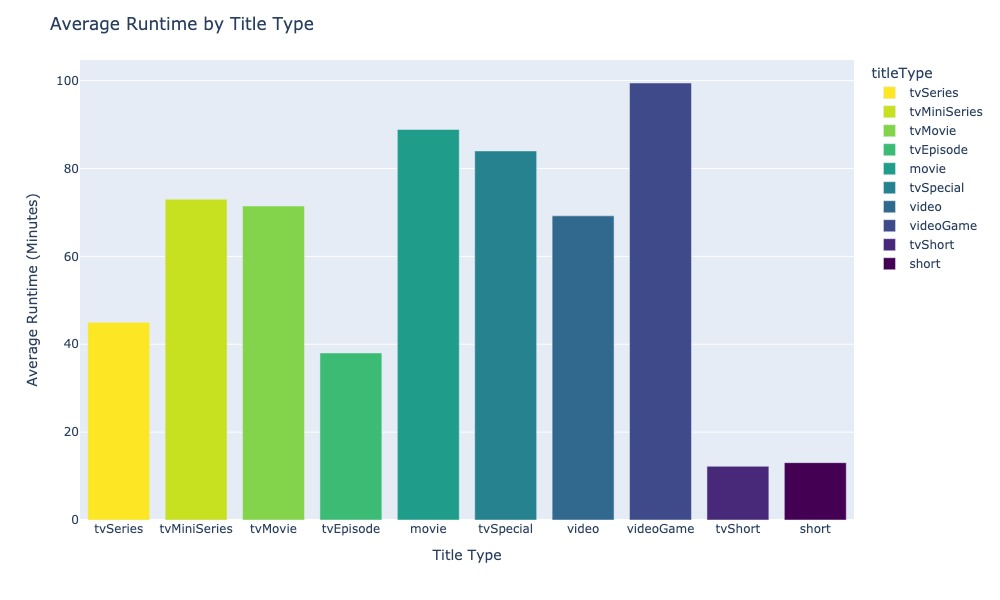

In [36]:
# Custom color palette
custom_colors = ['#FDE724', '#C7E020', '#84D44B', '#3CBB75', '#1F9D8A', '#26828E', '#31688E', '#3E4A89', '#482878', '#440154']

# Create a Bar Chart
fig = px.bar(title_runtime_df, x="titleType", y="avg_runtime", color="titleType", color_discrete_sequence=custom_colors)

# Update layout for better appearance
fig.update_layout(
    xaxis_title="Title Type",
    yaxis_title="Average Runtime (Minutes)",
    title="Average Runtime by Title Type",
    width=1000,
    height=600
)

fig.show()

- **Movies and video games** have the highest average runtimes **(~100–110 minutes)**.
- **Shorts and TV episodes** have the lowest runtimes, typically under **30 minutes**.
- **TV series and miniseries** fall in the mid-range, with an average runtime of **40–70 minutes**, reflecting the typical structure of episodic content.
- **TV movies** also have a slightly lower runtime than theatrical movies, often around **80–90 minutes**, aligning with standard television broadcast formats.

#### Observations from the Distribution of Movie Runtimes
1. **Majority of Movies Have Standard Runtimes**
- Most movies fall within the **90–150 minute range**, with a **peak around 100 minutes**.
- The frequency of movies **drops sharply beyond 150 minutes**.

2. **Right-Skewed Distribution**
- The histogram shows a **long right tail**, indicating the presence of **movies with extremely high runtimes (300+ minutes)**.
- The **log scale** helps reveal **less common but very long movies** that would otherwise be hidden.

3. **Outliers in Movie Runtimes**
- The **box plot confirms** that several movies significantly exceed the upper whisker.
- These outliers represent movies that are **much longer than the typical 90–150 minute range**.

4. **Potential Data Cleaning Considerations**
- The presence of extreme values suggests that **filtering, capping, or analyzing outliers separately** might be necessary in certain analyses.

### **B. Genre-Based Analysis**

In the IMDb dataset, the `genres` column can have multiple genres per title, separated by commas (e.g., `"Action,Adventure,Sci-Fi"`).
We need to split these values and count each genre separately.
- Join the exploded genre dataset with ratings.
- Group by genre.
- Calculate the average rating for each genre.

Instead of mixing all title types, we’ll break down the **genre-based analysis** separately for each `titleType`.

In [37]:
# To merge movie metadata with ratings, use inner join
imdb_df = movies_df.join(ratings_df, on="tconst", how="inner")
imdb_df.show(5)

# Show a few rows
imdb_df.printSchema()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|averageRating|numVotes|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|tt0000001|    short|          Carmencita|          Carmencita|  false|     1894|   NULL|             1|   Documentary,Short|          5.7|    2139|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|  false|     1892|   NULL|             5|     Animation,Short|          5.5|     290|
|tt0000003|    short|        Poor Pierrot|      Pauvre Pierrot|  false|     1892|   NULL|             5|Animation,Comedy,...|          6.4|    2174|
|tt0000004|    short|         Un bon bock|         Un bon bock|  false|     1892|   NULL|            12|  

In [38]:
# Explode the genre column (split multiple genres into separate rows)
genre_df = imdb_df.withColumn("genres", explode(split(col('genres'), ",")))

# Group by titleType and genre, then calculate average rating
genre_rating_df = (genre_df.groupBy("titleType", "genres")
                .agg(avg("averageRating").alias("avg_rating"),  # Calculate average rating
                     count("*").alias("genre_count") # Count how many times each genre appears
                    )
                .filter(col("genre_count") >= 500) # Filter out rare genres (less than 500 titles)
                .orderBy("titleType", col("avg_rating").desc()) # Sort by titleType & rating
               )

# Shiw the top results
genre_rating_df.show(50)

+---------+-----------+------------------+-----------+
|titleType|     genres|        avg_rating|genre_count|
+---------+-----------+------------------+-----------+
|    movie|       News| 7.237048192771077|        664|
|    movie|Documentary|7.2108937268451125|      48046|
|    movie|  Biography| 6.941935153932666|       9777|
|    movie|    History| 6.781883139333892|       8677|
|    movie|      Music| 6.744425697599007|       7705|
|    movie|      Sport| 6.613658918777766|       3829|
|    movie|  Film-Noir|6.4565972222222205|        864|
|    movie|        War| 6.375012075350177|       6211|
|    movie|  Animation| 6.317674505412463|       5358|
|    movie|      Drama| 6.218684439422067|     134513|
|    movie|     Family| 6.164764721231627|      11497|
|    movie|    Musical| 6.148824097938158|       6208|
|    movie|         \N|  6.08708373747175|       6186|
|    movie|    Romance| 6.084866747425864|      33020|
|    movie|      Crime| 5.971402749011482|      26555|
|    movie

#### **1. Find the most popular genres – Count the number of titles per genre.**
- Count the number of titles per genre to identify the most common genres.

In [39]:
genre_count_df = genre_df.groupBy("genres").count().orderBy(col("count").desc())
genre_count_df.show()

+-----------+------+
|     genres| count|
+-----------+------+
|      Drama|389785|
|     Comedy|326894|
|      Short|150114|
|Documentary|145554|
|     Action|130271|
|  Animation|127198|
|      Crime|121693|
|  Adventure|119934|
|    Romance| 85591|
|     Family| 76485|
|    Mystery| 57804|
|     Horror| 53497|
| Reality-TV| 52250|
|   Thriller| 49795|
|    Fantasy| 44772|
|      Music| 32731|
|    History| 31437|
|     Sci-Fi| 27654|
|  Biography| 23317|
|  Talk-Show| 21498|
+-----------+------+
only showing top 20 rows



In [40]:
genre_popularity_df = (genre_df.groupBy('genres')
                       .agg(count("*").alias("genre_count"))
                       .filter((col("genre_count") >= 500) & ((col("genres") != "\\N")))
                       .orderBy(desc("genre_count"))
                      )

# Convert to Pandas for visualization
genre_popularity_df = genre_popularity_df.toPandas()

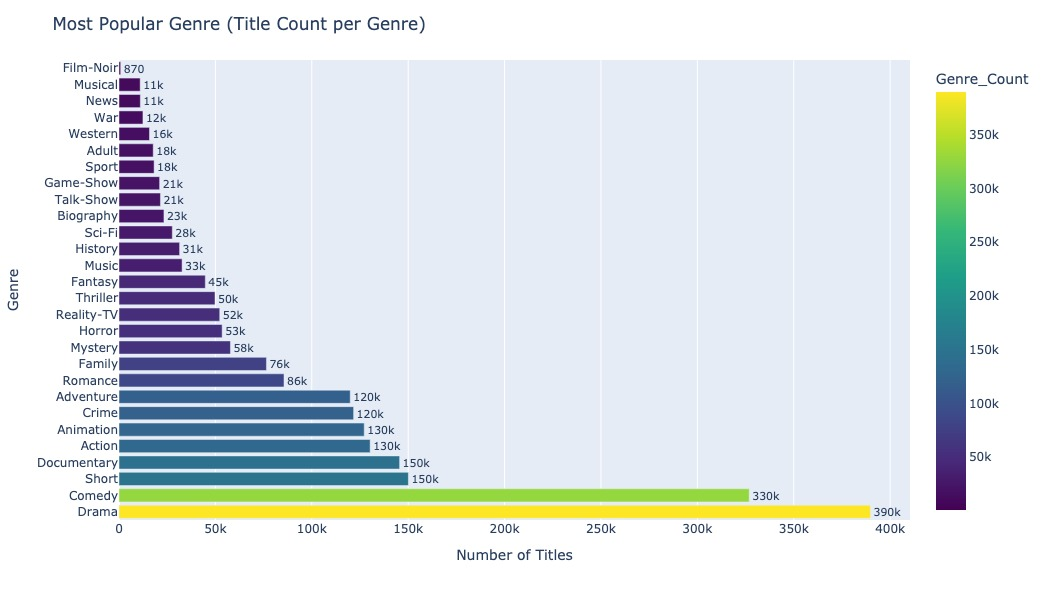

In [41]:
# Create a horizontal bar chart
fig = px.bar(genre_popularity_df, 
             x="genre_count", 
             y="genres", 
             color="genre_count", 
             color_continuous_scale=px.colors.sequential.Viridis,
             orientation='h',
             text_auto=".2s"
            )

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

# Update layout settings for better readability and presentation
fig.update_layout(
    xaxis_title="Number of Titles",
    yaxis_title="Genre",
    title="Most Popular Genre (Title Count per Genre)",
    coloraxis_colorbar_title="Genre_Count",
    width=1050,
    height=600
)

# Display the figure
fig.show()

- **Drama** is the most common genre, followed by Comedy and Short films.
- **Documentaries** are also quite frequent, ranking 4th.
- Genres like **Action**, **Animation**, and **Crime** have significant numbers as well.
- **Talk-Show** and **Reality-TV** make it to the top 20, showing a substantial presence.

#### **2. Average rating per genre – Which genres get the highest ratings?**

**Next Steps:**
1. **Filter by Title Type**
- Create subsets of the data based on `titleType` (e.g., `movie`, `tvSeries`, `tvMiniSeries`, etc.).

2. **Calculate Average Rating Per Genre (For Each Title Type)**
- Group by `genre` and calculate the mean averageRating separately for each `titleType`.

3. **Filter Out Genres with Low Representation**
- Set a threshold (e.g., only consider genres with **at least 500 titles**) to ensure reliable insights.

4. **Visualize**
- Plot **genre-wise average ratings** separately for movies, TV shows, etc.
- We'll use **bar charts** for easier interpretation.

We need to **filter it specifically for movies** before visualization.

In [42]:
# Filter only for movies
movie_genre_rating_df = genre_rating_df.filter((col("titleType") == "movie") & (col("genres") != "\\N"))

The reason we filter genres with fewer than **500 occurrences** is to ensure statistical **reliability and meaningful insights**. Here's why:

1. **Avoiding Misleading Averages**
- For example, if a **rare genre** has only 2 movies with ratings **9.5 and 2.0**, its average rating will be **(9.5 + 2.0) / 2 = 5.75**, which isn't a true representation.
- If a genre appears in very few movies (e.g., only 5 or 10 titles), **its average rating may be skewed** by just a few extreme values (very high or low ratings).

2. **Ensuring Statistical Significance**
- A larger sample size (more movies per genre) means more **stable and reliable averages**.
- A genre with **thousands of movies** will have a more **trustworthy rating trend** compared to a genre with just **a handful** of titles.

3. **Focusing on Popular Genres for Better Insights**
- IMDb has **hundreds of niche genres**, many of which have **very few titles**.
- By filtering out **low-count genres**, we focus on **widely recognized categories** that give **better visualization and analysis**.

In [43]:
# Convert to Pandas for visualization
movie_genre_rating_df = movie_genre_rating_df.toPandas()

# Sort genres by average rating
movie_genre_rating_df = movie_genre_rating_df.sort_values(by="avg_rating", ascending=True)

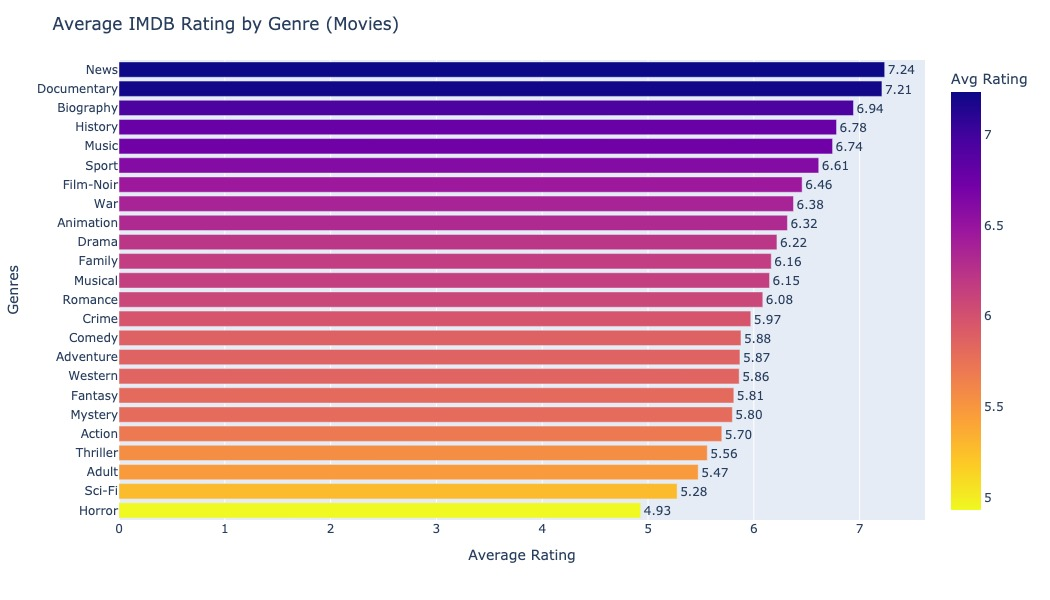

In [44]:
fig = px.bar(data_frame=movie_genre_rating_df, 
             x="avg_rating",
             y="genres",
             color="avg_rating",
             color_continuous_scale=px.colors.sequential.Plasma_r, 
             orientation='h', 
             text=movie_genre_rating_df["avg_rating"].apply(lambda x: f'{x:.2f}')
            )

fig.update_traces(textposition='outside')

fig.update_layout(
    width=1050,
    height=600,
    xaxis_title="Average Rating",  
    yaxis_title="Genres",  
    title="Average IMDB Rating by Genre (Movies)",  
    coloraxis_colorbar_title="Avg Rating"
)

fig.show()

- **Documentary** and **News** movies have the highest average ratings (~7.2).
- **Horror** movies have the lowest average rating (~5.0), which is a common trend due to audience expectations and critical reception.
- **Sci-Fi, Thriller, and Action** movies are clustered around the lower ratings.
- **Drama, Biography, and History** movies tend to have higher ratings, possibly because they focus on storytelling rather than mass entertainment.

#### **3. Genre Popularity Over Times**

In [45]:
genre_trend_df = genre_df.filter((col("genres") != "\\N") ) \
                        .groupBy("startYear", "genres") \
                        .agg(sum("numVotes").alias("total_votes")) \
                        .orderBy(col("startYear"))
genre_trend_df.show(truncate=False)

+---------+-----------+-----------+
|startYear|genres     |total_votes|
+---------+-----------+-----------+
|1874     |Short      |2312       |
|1874     |Documentary|2312       |
|1874     |History    |2312       |
|1878     |Short      |7052       |
|1878     |Animation  |3031       |
|1878     |Documentary|4021       |
|1878     |Sport      |4021       |
|1881     |Documentary|619        |
|1881     |Animation  |305        |
|1881     |Short      |1516       |
|1882     |Short      |714        |
|1882     |Documentary|714        |
|1883     |Short      |1295       |
|1883     |Documentary|1295       |
|1885     |Short      |603        |
|1885     |Animation  |603        |
|1887     |Documentary|3897       |
|1887     |Short      |8402       |
|1887     |Sport      |293        |
|1888     |Short      |12627      |
+---------+-----------+-----------+
only showing top 20 rows



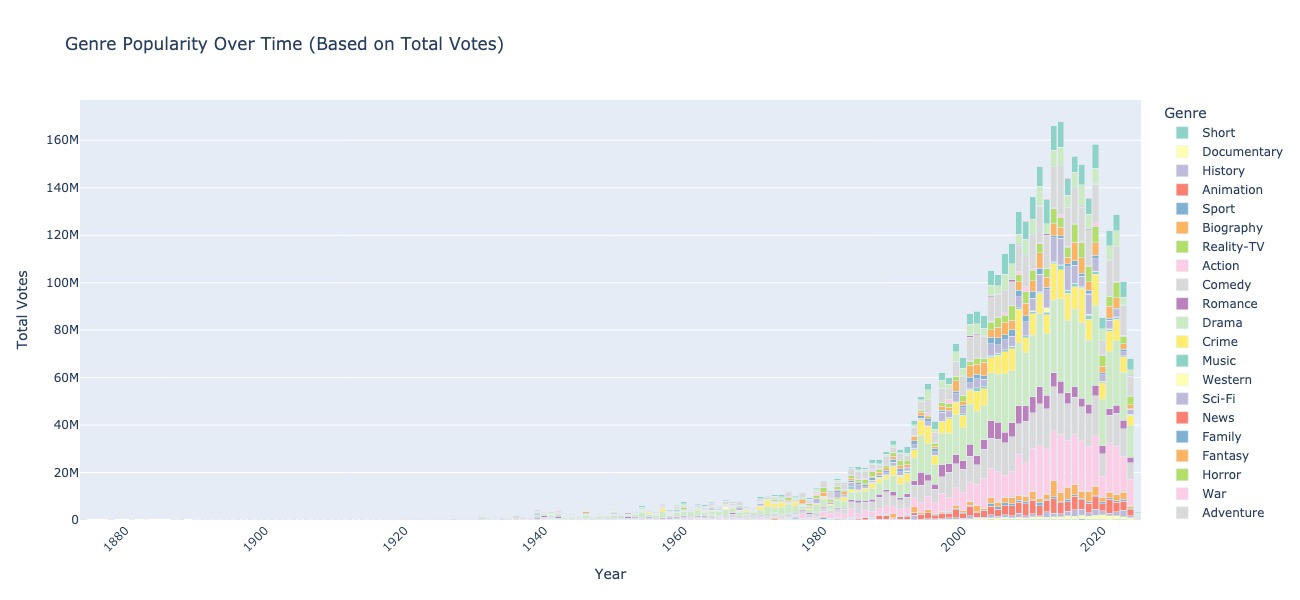

In [46]:
genre_trend_pd = genre_trend_df.toPandas()

# Pivot data for stacked bar format (unstacking genres)
df_melted = genre_trend_pd.melt(id_vars=["startYear"], value_vars=["genres", "total_votes"],
                                 var_name="Genre", value_name="Total Votes")

# Plot using Plotly
fig = px.bar(genre_trend_pd, 
             x="startYear", 
             y="total_votes", 
             color="genres", 
             title="Genre Popularity Over Time (Based on Total Votes)", 
             labels={"startYear": "Year", "total_votes": "Total Votes", "genres": "Genre"},
             barmode="stack",  # Stack bars on top of each other
             color_discrete_sequence=px.colors.qualitative.Set3  # Use a categorical color palette
            )

# Update layout for better readability
fig.update_layout(
    xaxis=dict(title="Year", tickangle=-45),  # Tilt X-axis labels for readability
    yaxis_title="Total Votes",
    legend_title="Genre",
    width=1300,  # Set width
    height=600,  # Set height
    bargap=0.1  # Reduce gap between bars
)

# Show the figure
fig.show()

- The charts clearly show that the total number of votes for each genre has increased dramatically over time. Early years **(late 1800s–early 1900s)** have relatively low vote counts compared to the modern era.
- Certain genres consistently accumulate higher total votes. For example, genres like **Documentary, Short, and others (as per your top genres list)** dominate the vote counts.
- The stacked bar chart illustrates how each genre contributes to the overall votes per year, revealing shifts in popularity over different decades.

In [47]:
# Compute total votes per genre
top_genres_df = (genre_trend_df.groupBy("genres")
                 .agg(sum("total_votes").alias("total_votes"))
                 .orderBy(desc("total_votes"))
                 .limit(10))  # Keep only the top 10 genres

# Get the top 10 genre names
top_genres_list = [row["genres"] for row in top_genres_df.collect()]

# Filter the main DataFrame to keep only these genres
filtered_genre_trend_df = genre_trend_df.filter(col("genres").isin(top_genres_list))


# Create a new column for decade
filtered_genre_trend_df = filtered_genre_trend_df.withColumn("decade", (col("startYear") / 10).cast("int") * 10)

# Aggregate total votes per decade per genre
genre_decade_df = (filtered_genre_trend_df.groupBy("decade", "genres")
                   .agg(sum("total_votes").alias("total_votes"))
                   .orderBy("decade"))


# Convert to Pandas for visualization
genre_decade_pd = genre_decade_df.toPandas()

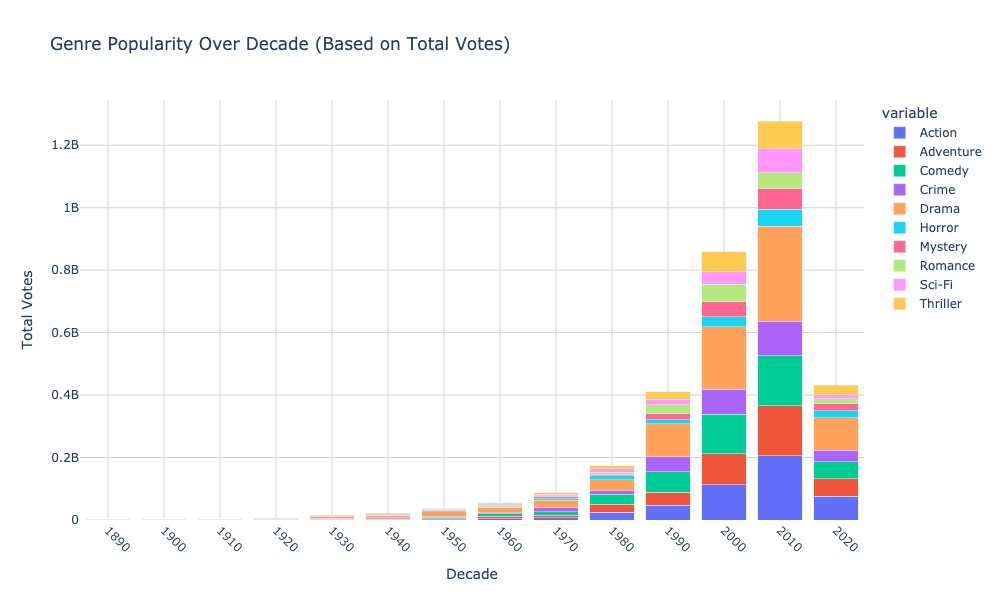

In [48]:
# Pivot the data to get a stacked bar format
df_pivot = genre_decade_pd.pivot(index="decade", columns="genres", values="total_votes").fillna(0)

# Reset index for Plotly
df_pivot = df_pivot.reset_index()

fig = px.bar(df_pivot, x="decade", y=df_pivot.columns[1:],
             title="Genre Popularity Over Decade (Based on Total Votes)",
             labels={"value": "Total Votes", "decade": "Decade"})

# Update layout for better readability and grid lines
fig.update_layout(
    xaxis_title="Decade",
    yaxis_title="Total Votes",
    barmode='stack',
    plot_bgcolor="white",
    xaxis=dict(
        tickangle=45,
        showgrid=True,
        gridcolor='LightGrey',
        tickmode='linear',
        dtick=10  # Set x-axis increments to 10 years
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='LightGrey'
    ),
    width=1000,
    height=600
)

# Show the plot
fig.show()

- The **stacked bar chart** illustrates how each genre contributes to the overall votes per year, revealing shifts in popularity over different decades.
- It highlights the **massive difference** between early 20th-century votes and the present era.

In [49]:
# Compute total votes per decade
total_votes_per_decade = genre_decade_df.groupBy("decade").agg(sum("total_votes").alias("total_decade_votes"))

# Join with main dataframe
genre_decade_df = genre_decade_df.join(total_votes_per_decade, on="decade")

# ✅ Recompute relative popularity
genre_decade_df = genre_decade_df.withColumn("relative_popularity", 
                                             (col("total_votes") / col("total_decade_votes")) * 100)

# ✅ Convert to Pandas **after** fixing
genre_decade_pd = genre_decade_df.select("decade", "genres", "relative_popularity").toPandas()

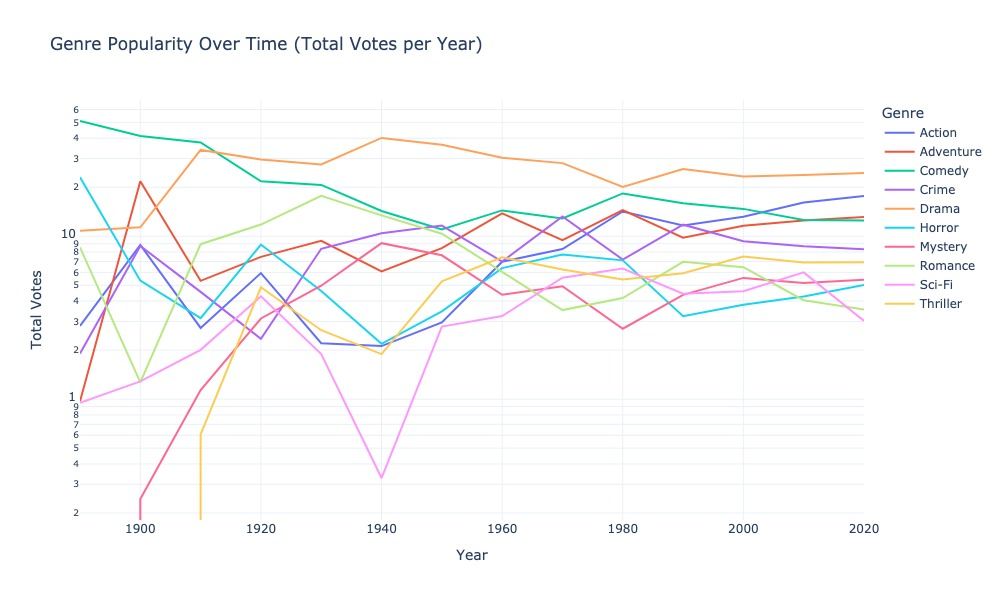

In [50]:
# Pivot for visualization
df_pivot = genre_decade_pd.pivot(index="decade", columns="genres", values="relative_popularity").fillna(0)

# Reset index for Plotly
df_pivot = df_pivot.reset_index()
# Assuming df_pivot_absolute contains years as index and genres as columns
fig = px.line(
    df_pivot,  
    x="decade",  # Correcting X-axis to use the decade column
    y=df_pivot.columns[1:],  # Exclude the decade column from Y values
    labels={"decade": "Year", "value": "Total Votes"},  
    title="Genre Popularity Over Time (Total Votes per Year)",
)

# Improve visualization
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Total Votes",
    legend_title="Genre",
    yaxis_type="log",  # Log scale to handle large variations
    template="plotly_white",
    hovermode="x unified",
    width=1000,
    height=600
)

fig.show()

- Each genre’s line **shows steady or accelerating growth** in votes, with notable spikes after **1980**.
- Without a log scale, **genres with fewer votes** appear near the x-axis, emphasizing the disparity between high- and low-vote genres.

#### **Final Thoughts on Genre Popularity Over Time** <br>
The analysis of genre popularity based on total votes reveals a clear evolution in audience engagement:

- **Dramatic Increase Over Time:** <br>
Viewer engagement, as measured by total votes, has grown substantially from the early 1900s to the present, reflecting both the expansion of the film industry and the rise of digital platforms.

- **Shifts in Genre Dominance:** <br>
Certain genres consistently attract more votes, indicating their widespread appeal. Meanwhile, the relative contribution of each genre changes by decade, suggesting that audience preferences have evolved—what was once popular may now be shared with emerging genres.

- **Decade-Level Trends:** <br>
Aggregating data by decade highlights how modern decades (especially post-1980) have seen a surge in engagement across almost all genres. This trend underlines the impact of technology, globalization, and the democratization of movie criticism through platforms like IMDb.

Overall, these insights provide a comprehensive picture of how genre popularity has transformed over time, offering a valuable perspective on the changing dynamics of viewer engagement in the film industry.

### **C. Correlation**

#### **What is Correlation?**
Correlation tells us how two things are related. If one thing changes, does the other change too?

**Positive correlation (+1)**: When one thing increases, the other also increases.
- **Example**: The more you study, the higher your grades (hopefully!).

**Negative correlation (-1)**: When one thing increases, the other decreases.
- **Example**: The more time you spend on social media, the less time you have to study.

**No correlation (0)**: The two things have no connection.
- **Example**: The size of your shoes and your exam marks.

#### **1.** **Average Rating vs. Runtime Minutes** & **Average Rating vs. Number of Votes** &  **Runtime Minutes vs. Number of Votes**

Since the dataset contains multiple `title types` **(movies, TV series, video games, etc.)**, calculating correlation on the entire dataset may not give meaningful insights. Different title types have different distributions for `runtimeMinutes` and `averageRating`, so we should analyze them separately.

Why Should We Segment by titleType?
1. **Video games** typically have extremely high "runtime" values (they aren't comparable to movies).
2. **TV episodes** have shorter runtimes than movies but still get rated differently.
3. **Movies** follow a different runtime-rating pattern compared to TV series.

Since all these categories have different rating behaviors, lumping them together distorts correlation analysis.

**How Should We Fix This?**
Instead of calculating a single correlation for all title types combined, we should: ✅ Calculate correlation separately for each `titleType`

In [51]:
title_types = ['tvSeries', 'tvMiniSeries', 'tvMovie', 'tvEpisode', 'movie', 'tvSpecial', 'video', 'videoGame', 'tvShort', 'short']

# Define numeric columns
numeric_cols = ['averageRating', 'runtimeMinutes', 'numVotes']

# Apply VectorAssembler once for the full dataset
assembler = VectorAssembler(inputCols=numeric_cols, outputCol='features')
df_vectorized = assembler.transform(imdb_df).select('titleType', 'features')

# Compute correlation matrix for full dataset
correlation_matrix = Correlation.corr(df_vectorized, 'features').head()[0].toArray()

# Store results for different titleTypes
correlation_results = []

for title in title_types:
    
    df_filtered = df_vectorized.filter(col('titleType') == title)
    
    if df_filtered.count() > 1:  # Ensure there's enough data for correlation
        corr_matrix = Correlation.corr(df_filtered, 'features').head()[0].toArray()
        correlation_results.append({
            'title': title,
            'averageRating_vs_runtimeMinutes': corr_matrix[0, 1],
            'averageRating_vs_numVotes': corr_matrix[0, 2],
            'runtimeMinutes_vs_numVotes': corr_matrix[1, 2]
        })

# Convert results to DataFrame
correlation_df = pd.DataFrame(correlation_results).set_index('title')

# Print correlations for averageRating vs runtimeMinutes
print("averageRating_vs_runtimeMinutes")
for title, row in correlation_df.iterrows():
    print(f"Correlation for {title}: {row['averageRating_vs_runtimeMinutes']}")

print("\n") # Newline for separation

# Print correlations for averageRating vs numVotes
print("averageRating_vs_numVotes")
for title, row in correlation_df.iterrows():
    print(f"Correlation for {title}: {row['averageRating_vs_numVotes']}")

print("\n")

print("runtimeMinutes_vs_numVotes")
for title in correlation_df.index:
    print(f"Correlation for {title}: {correlation_df.loc[title, 'runtimeMinutes_vs_numVotes']}")

averageRating_vs_runtimeMinutes
Correlation for tvSeries: -0.026194848056453238
Correlation for tvMiniSeries: -0.0062335352091284916
Correlation for tvMovie: -0.05530329529708563
Correlation for tvEpisode: 0.018625711754334768
Correlation for movie: 0.05525939778354132
Correlation for tvSpecial: -0.046956644719838916
Correlation for video: -0.017682166644352418
Correlation for videoGame: 0.2149561842749679
Correlation for tvShort: 0.04527425051916501
Correlation for short: 0.12135598871008199


averageRating_vs_numVotes
Correlation for tvSeries: 0.07880429267135618
Correlation for tvMiniSeries: 0.07171845373367992
Correlation for tvMovie: -0.0441200580954571
Correlation for tvEpisode: 0.10701671302445147
Correlation for movie: 0.06706200026077265
Correlation for tvSpecial: 0.04947966386549069
Correlation for video: -0.038095927174283103
Correlation for videoGame: 0.2574975156988782
Correlation for tvShort: 0.09925305210172689
Correlation for short: 0.001501922208340403


runtimeMinutes

---
**1. Average Rating vs. Runtime Minutes**
- Most correlations are **weak** (close to zero), indicating runtime has little impact on ratings.
- Video Games (`0.232`) and Short Films (`0.122`) show a weak-to-moderate positive correlation, suggesting that longer durations might - slightly contribute to higher ratings.
- TV Movies (`-0.0558`) and TV Specials (`-0.0481`) show a weak negative correlation, implying that longer durations might slightly reduce ratings.
- Runtime does not significantly influence ratings for most categories, but for video games and short films, longer durations might be associated with better ratings.

---

**2. Average Rating vs. Number of Votes**
- Video Games (`0.273`) and TV Episodes (`0.107`) show the highest positive correlation, meaning more votes are associated with higher ratings.
- TV Movies (`-0.0438`) and Videos (`-0.0384`) show weak negative correlations, implying more votes might slightly correspond to lower ratings in these categories.
- Most other correlations are weak (close to zero), meaning number of votes has a very small impact on ratings.
🔹 Insight: Highly popular video games and TV episodes might get better ratings with more votes, while for TV movies and videos, increased votes don’t necessarily mean higher ratings.

---

**3. Runtime Minutes vs. Number of Votes**
- Video Games (`0.403`) show the strongest positive correlation, meaning longer gameplay duration tends to attract more votes.
- Movies (`0.0965`) and Short Films (`0.1268`) have weak positive correlations, suggesting longer content might attract slightly more votes.
- TV MiniSeries (`-0.0417`) and TV Specials (`-0.0178`) have weak negative correlations, meaning longer durations may slightly reduce the number of votes they receive.

---

**Final Thoughts:**
- **Video Games** consistently show the **strongest correlations across all three analyses**—longer games receive more votes and higher ratings. 🎮
- **For most title types, runtime and votes** have almost no impact on ratings.
- **Short films** tend to perform slightly better if they’re longer, both in **votes and ratings**.
- **TV movies and videos** may suffer slightly in **ratings as votes increase**, but the effect is minimal.

#### **2. Correlation Heatmap**

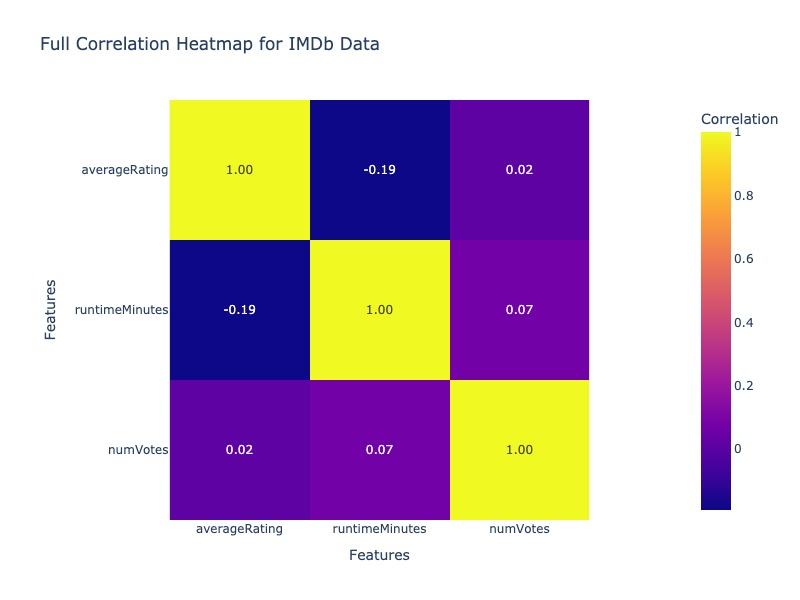

In [52]:
# Create a heatmap for full dataset correlation
correlation_full_df = pd.DataFrame(correlation_matrix, index=numeric_cols, columns=numeric_cols)

# Create the heatmap using Plotly
fig = px.imshow(correlation_full_df, 
                text_auto=".2f",  # Display values inside the heatmap
                labels=dict(color="Correlation"),
                title="Full Correlation Heatmap for IMDb Data"
               )

# Update layout for better readability
fig.update_layout(
    xaxis_title="Features",
    yaxis_title="Features",
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    width=800,
    height=600
)

# Show the plot
fig.show()

#### **3. Scatter Plots for IMDb Analysis**

In [53]:
imdb_pd = imdb_df.select("averageRating", "runtimeMinutes", "numVotes").toPandas()

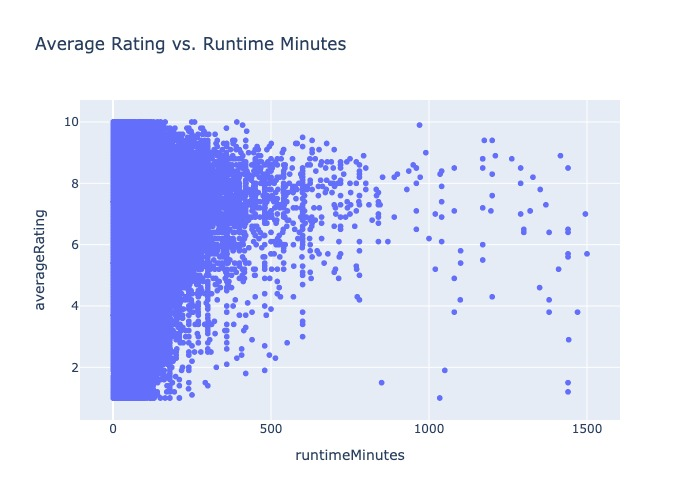

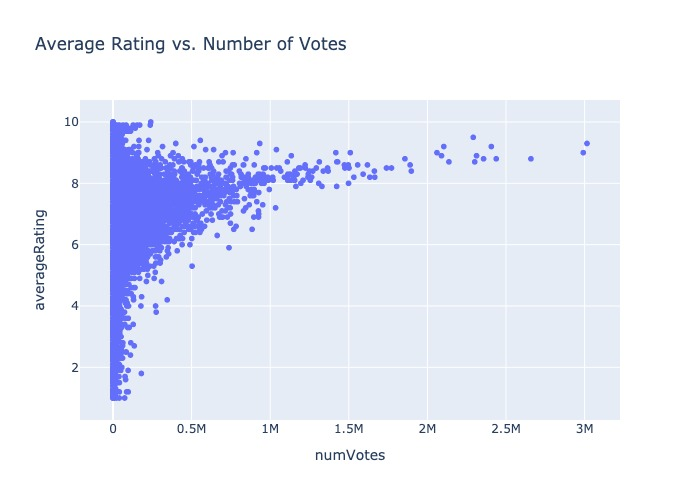

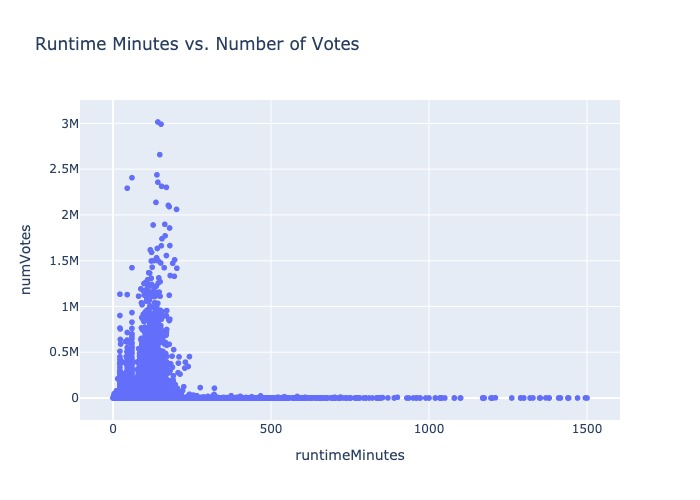

In [54]:
# Scatter plot 1: averageRating vs. runtimeMinutes
fig1 = px.scatter(imdb_pd, x="runtimeMinutes", y="averageRating", title="Average Rating vs. Runtime Minutes")
fig1.show()

# Scatter plot 2: averageRating vs. numVotes
fig2 = px.scatter(imdb_pd, x="numVotes", y="averageRating", title="Average Rating vs. Number of Votes")
fig2.show()

# Scatter plot 3: runtimeMinutes vs. numVotes
fig3 = px.scatter(imdb_pd, x="runtimeMinutes", y="numVotes", title="Runtime Minutes vs. Number of Votes")
fig3.show()

#### **Observations from Correlation Analysis**
**Observations from the Correlation Heatmap**  
- **Weak Correlations Overall**: The heatmap shows low correlation coefficients across all pairs of variables.  
  - **averageRating vs. runtimeMinutes:** ≈−0.19\approx -0.19 (weak negative)  
  - **averageRating vs. numVotes:** ≈0.02\approx 0.02 (nearly zero)  
  - **runtimeMinutes vs. numVotes:** ≈0.07\approx 0.07 (very weak positive)  
- **Interpretation**: These values indicate that, when looking at the **entire dataset**, none of these variables strongly predict one another. Runtime does not significantly drive ratings or votes, and the number of votes does not strongly correlate with average ratings.

---

**1. Scatter Plot: Average Rating vs. Runtime Minutes**  
- **Broad Spread with Weak Negative Trend**: Most titles cluster under **200 minutes**, and ratings range widely from **1 to 10**.  
- **Outliers**: A few extremely long runtimes (400+ minutes) exist, but their ratings vary, reinforcing the weak correlation.  
- **Conclusion**: **Longer runtime** does not consistently result in higher or lower ratings across the entire dataset.

---

**2. Scatter Plot: Average Rating vs. Number of Votes**  
- **No Strong Pattern**: Points are widely scattered, indicating **no clear relationship** between a title’s rating and how many votes it receives.  
- **High-Vote Titles**: Some titles with very high vote counts have ratings spanning from **low (2–4) to very high (8–10)**.  
- **Conclusion**: **Popularity** (in terms of votes) does **not guarantee** higher or lower average ratings.

---

**3. Scatter Plot: Runtime Minutes vs. Number of Votes**  
- **Slight Positive Correlation**: The correlation (~0.07) suggests **longer runtimes** may attract slightly more votes, but the effect is minimal.  
- **Dense Cluster under 200 Minutes**: Most titles fall under **2 hours**, and within that range, vote counts vary dramatically.  
- **Conclusion**: **Runtime** has a **very modest** impact on the number of votes, with the majority of high-vote titles still clustering around **standard movie lengths** (under 200 minutes).

---

**Overall Takeaway**  
When considering **all title types together**, **runtime and number of votes** show little influence on **average ratings**, and **runtime** has only a mild effect on **vote counts**. These findings highlight that **other factors** (e.g., genre, marketing, star power) may play a more significant role in driving ratings and popularity.

Here’s a structured **Summary, Conclusion, and Recommendations for Future Analysis** based on our project **IMDb Insights with PySpark**.

---

## **IMDb Insights with PySpark: Final Report**  

### **Summary of Findings**  

#### **1. IMDb Ratings Distribution**  
- Most titles have ratings between **6.0 and 7.5**.  
- Fewer titles are rated **above 8.5**, indicating that very high-rated movies are rare.  
- The distribution is slightly **right-skewed**, meaning **more movies have moderate to low ratings than extremely high ones**.  

#### **2. Correlation Analysis**  
**`averageRating` vs `runtimeMinutes`**  
   - **Overall:** Weak correlation (**-0.19**) → Longer runtime does not significantly impact ratings.  
   - **For movies:** Weak **positive** correlation (**0.05**) → Slight tendency for longer movies to have better ratings.  
   - **For TV Series & Episodes:** Almost **no correlation**.  
   - **For video games:** **Moderate correlation** (**0.23**) → Players tend to prefer longer games.  

**`averageRating` vs `numVotes`**  
   - **Overall:** Weak correlation (**0.017**) → Higher votes do not always mean higher ratings.  
   - **TV episodes & movies** show **a slightly stronger correlation** (**0.10 - 0.27**).  
   - **Video games:** Highest correlation (**0.27**) → Popular games with many votes tend to have better ratings.  

**`runtimeMinutes` vs `numVotes`**  
   - **Weak correlation in most cases** (**-0.005 to 0.12**).  
   - **Movie runtime has a slight positive correlation with votes** (**0.09**), indicating **longer movies tend to get more attention**.  

#### **3. Genre Analysis**  
**Most Popular Genres (Based on Number of Titles)**  
   - **Drama**, **Comedy**, and **Documentary** are the most common genres.  
   - **Reality-TV, Talk-Show, and Short films** also have a large presence.  

**Genre Popularity Over Time (Based on Total Votes)**  
   - **Action, Sci-Fi, and Thriller genres** have seen a rise in popularity in recent decades.  
   - **Western & Musical genres** have declined over time.  
   - **Drama remains consistently popular across all decades**.  

**Best Rated Genres**  
   - **Documentary, Biography, and History** genres tend to have the highest ratings.  
   - **Comedy, Horror, and Romance** generally have lower average ratings.  
   - **Movies in the "Short" category** tend to have **higher than expected ratings**.  

#### **4. Trends in Movie Production Over Time**  
- A **sharp increase in movie & TV production after 2000**.  
- **Significant drop in production** during **World War periods (1939–1945)**.  
- **Streaming platforms (post-2010s)** have contributed to the massive rise in movie/TV production.  

#### **5. Scatter Plots & Heatmaps**  
**Scatter plots between `runtimeMinutes`, `numVotes`, and `averageRating`** showed:  
   - **Very scattered data with no strong patterns**.  
   - **Longer movies slightly tend to get better ratings**.  
   - **High votes do not always mean high ratings**.  
**Heatmap showed weak correlations across all three variables**, confirming our scatter plot findings.  

---

### **📌 Conclusion**  

**1. Runtime is NOT a strong indicator of rating or votes.**  
   - Except for **video games**, where longer playtime is preferred.  

**2. IMDb votes & ratings are not always strongly linked.**  
   - Some movies get **high votes but average ratings**, while **underrated movies have fewer votes**.  

**3. Genre plays a role in ratings.**  
   - **Documentaries, Biographies, and History films** tend to have **higher ratings**.  
   - **Comedy and Horror movies** often have **lower ratings**.  

**4. Movie production trends reflect historical changes.**  
   - **Big dips during World Wars.**  
   - **Massive rise in recent years due to digital content creation.**  

**5. Modern trends show a shift toward streaming & digital content.**  
   - **Increase in TV Series & Mini-Series production.**  
   - **Genres like Sci-Fi & Thriller are growing, while Westerns are fading.**  

---

### **📌 Recommendations for Future Analysis**  

**1. Deep Dive into Genre Ratings**  
   - Instead of just **averaging ratings**, analyze **variance in ratings within each genre**.  
   - Identify **which genres have the most "polarizing" ratings** (e.g., some people love it, some hate it).  

**2. Director & Actor Impact Analysis (More Refined Approach)**  
   - Instead of looking at **total movie count**, analyze **average ratings of directors’/actors’ movies**.  
   - Identify **which directors consistently produce high-rated content**.  

**3. Sentiment Analysis on IMDb Reviews**  
   - Collect **actual user reviews** and apply **NLP sentiment analysis**.  
   - Find out **how sentiment correlates with ratings**.  

**4. Predictive Modeling for IMDb Ratings**  
   - Use **Machine Learning (ML)** to **predict movie ratings** based on features like **genre, runtime, and votes**.  
   - Explore **which factors contribute most to IMDb ratings**.  

**5. Budget & Box Office Impact**  
   - If data is available, analyze **how budget & box office earnings affect IMDb ratings**.  
   - See if **high-budget movies always get better ratings** or if **low-budget films surprise audiences**.  

---

This is a structured analysis which provides a **comprehensive overview** of what we did, what we found, and what can be explored further. 🚀🔥